### 

### Exploration of pairwise string similarity algorithms 

Numerous string similarity measuring algirithms are studied below to understand how they work and which one would be the most stuitable. The end goal is to generate a pairwise dissimilarity matrix from (one of) the best algorithms. With such a matrix, we can use technqiues like Multi Dimensional Scaling to plot API strings as points. Clustering algorithms could then be used used to further understand the cohesity of API names. 

In [522]:
import scipy 
import numpy as np
import strsimpy 
from Bio import pairwise2
from Bio.Seq import Seq 
from Bio.pairwise2 import format_alignment 
import matplotlib
import matplotlib.pyplot as plt

In [523]:
similar_strings  = ["user_id", "userid", "UserId", "userID"]
different_strings = ["CachedNames", "keywordlength", "PATHDIRECTORY"]

#### Levenshtein
The Levenshtein distance between two words is the minimum number of single-character edits (insertions, deletions or substitutions) required to change one word into the other.

It is a metric string distance. The implementation we use is dynamic programming (Wagner–Fischer algorithm).

The space requirement is $\mathcal{O}(M)$. The algorithm runs in $\mathcal{O}(M \times N)$.

In [524]:
from strsimpy.levenshtein import Levenshtein
levenshtein = Levenshtein()
print('The levenshtein.distance between {} and {} is {}'. \
    format(similar_strings[0], similar_strings[1], levenshtein.distance(similar_strings[0], similar_strings[1])))


The levenshtein.distance between user_id and userid is 1


Since we can findd out pairwise distances betwen two strings, we can use such distances as our dissimilarty to generate dissimilarity matrices. such matrices can then help use "plot" words. Code below to plot will be recycled for each algorithm. 

In [525]:
def calculate_dissimilarity_matrix(api_strings, pairwise_dissimilarity_measure):
    size = len(api_strings)
    inconsistency_matrix = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            if i < j:
                string1  = api_strings[i]
                string2 = api_strings[j]
                if len(string1) == 0:
                    return len(string2)
                if(len(string2) == 0):
                    return len(string1)

                dissimilarity = pairwise_dissimilarity_measure(string1, string2)
                inconsistency_matrix[i][j] = dissimilarity
    inconsistency_matrix = inconsistency_matrix + inconsistency_matrix.T - np.diag(np.diag(inconsistency_matrix))
    return inconsistency_matrix

In [526]:
inconsistency_matrix = calculate_dissimilarity_matrix(similar_strings, levenshtein.distance)
print(inconsistency_matrix)

[[0. 1. 3. 3.]
 [1. 0. 2. 2.]
 [3. 2. 0. 2.]
 [3. 2. 2. 0.]]


We can now use this dissimilarity matrix to convert the words into a set of points on the $2D$ plane. We use MDS for this. 

In [527]:
def plot_words(inconsistency_matrix, title, annotate=False):
    embedding = MDS(n_components=2, dissimilarity  = "precomputed")
    fitted_strings = embedding.fit_transform(inconsistency_matrix)
    fitted_strings
    x = fitted_strings[:,0]
    y = fitted_strings[:,1]
    plt.scatter(x, y)
    if annotate:
        for i, txt in enumerate(similar_strings):
            plt.annotate(txt, (x[i], y[i]))
    plt.title(title)

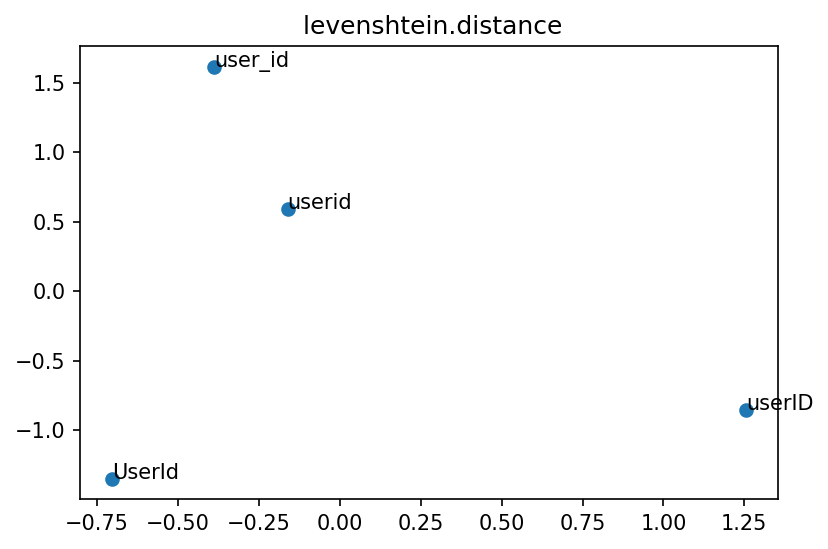

In [528]:

matplotlib.rcParams["figure.dpi"] = 150
plot_words(inconsistency_matrix, title = " levenshtein.distance", annotate=True)

#### Normalized Levenshtein
This distance is computed as levenshtein distance divided by the length of the longest string. The resulting value is always in the interval [0.0 1.0] but it is not a metric anymore. 



In [529]:
from strsimpy.normalized_levenshtein import NormalizedLevenshtein

normalized_levenshtein = NormalizedLevenshtein()
inconsistency_matrix = calculate_dissimilarity_matrix(similar_strings, normalized_levenshtein.distance)
print(inconsistency_matrix)


[[0.         0.14285714 0.42857143 0.42857143]
 [0.14285714 0.         0.33333333 0.33333333]
 [0.42857143 0.33333333 0.         0.33333333]
 [0.42857143 0.33333333 0.33333333 0.        ]]


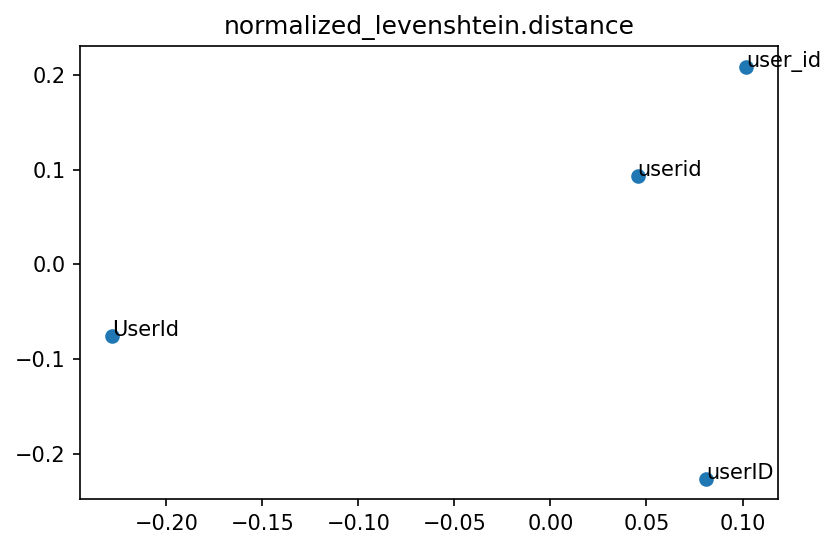

In [530]:
plot_words(inconsistency_matrix, title = "normalized_levenshtein.distance", annotate=True)

#### Jaro-Winkler
Jaro-Winkler is a string edit distance that was developed in the area of duplicate detection. The Jaro-Winkler distance metric is designed and best suited for short strings such as person names, and to detect typos. As the vocabulary artifact is presumed to contain only reasonably long strings, this is chosen to be the most relevant variant of edit-distance to our problem. 

The algorithm runs in $\mathcal{O}(M \times N)$.

In [531]:
from strsimpy.jaro_winkler import JaroWinkler

jarowinkler = JaroWinkler()
print('The jarowinkler.distance between {} and {} is {}'. \
    format(similar_strings[0], similar_strings[1], jarowinkler.distance(similar_strings[0], similar_strings[1])))

The jarowinkler.distance between user_id and userid is 0.02857142857142858


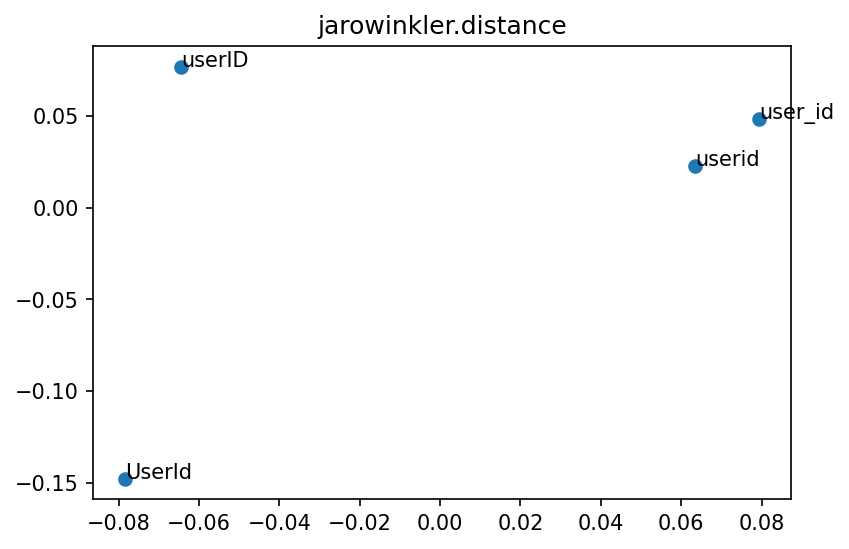

In [532]:
inconsistency_matrix = calculate_dissimilarity_matrix(similar_strings, jarowinkler.distance)
plot_words(inconsistency_matrix, title = "jarowinkler.distance", annotate=True)

#### Longest Common Subsequence
The longest common subsequence (LCS) problem finds the longest subsequence common to two sequences. Subsequences are not required to occupy consecutive positions within the original sequences.

The LCS distance between strings $X$ (of length $n$) and $Y$ (of length $m$) is $n + m - 2 (LCS(X, Y)).$ It ranges from $[0, n + m]$

It has space and run time complexity  of $\mathcal{O}(M \times N)$.


In [533]:
from strsimpy.longest_common_subsequence import LongestCommonSubsequence
lcs = LongestCommonSubsequence()
print('The lcs.distance between {} and {} is {}'. \
    format(similar_strings[0], similar_strings[1], lcs.distance(similar_strings[0], similar_strings[1])))

The lcs.distance between user_id and userid is 1


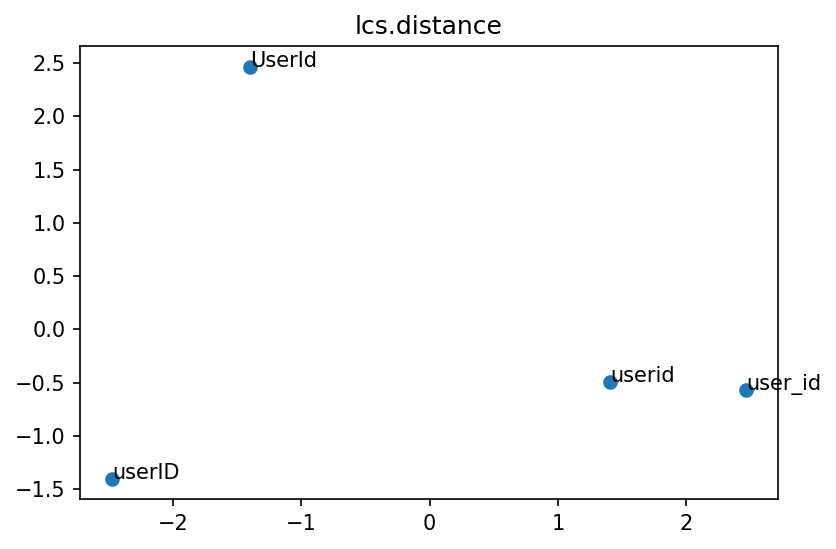

In [534]:
inconsistency_matrix = calculate_dissimilarity_matrix(similar_strings, lcs.distance)
plot_words(inconsistency_matrix, title = "lcs.distance", annotate=True)

#### Metric Longest Common Subsequence
Based on Longest Common Subsequence, except now distance is
$ 1 - \frac{|LCS(X, Y)|}{max(|X|, |Y|)} $

In [535]:
from strsimpy.metric_lcs import MetricLCS

metric_lcs = MetricLCS()
print('The metric_lcs.distance between {} and {} is {}'. \
    format(similar_strings[0], similar_strings[1], metric_lcs.distance(similar_strings[0], similar_strings[1])))

The metric_lcs.distance between user_id and userid is 0.1428571428571429


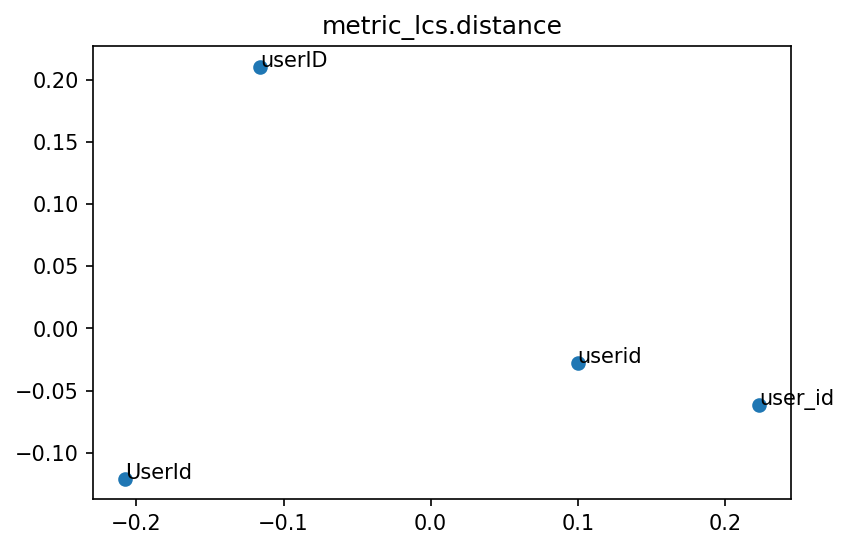

In [536]:
inconsistency_matrix = calculate_dissimilarity_matrix(similar_strings, metric_lcs.distance)
plot_words(inconsistency_matrix, title = "metric_lcs.distance", annotate=True)

#### N-Gram 
The algorithm uses affixing with special character '\n' to increase the weight of first characters. The normalization is achieved by dividing the total similarity score the original length of the longest word.

In [537]:
from strsimpy.ngram import NGram
fourgram = NGram(4)
print('The fourgram.distance between {} and {} is {}'. \
    format(similar_strings[0], similar_strings[1], fourgram.distance(similar_strings[0], similar_strings[1])))

The fourgram.distance between user_id and userid is 0.25


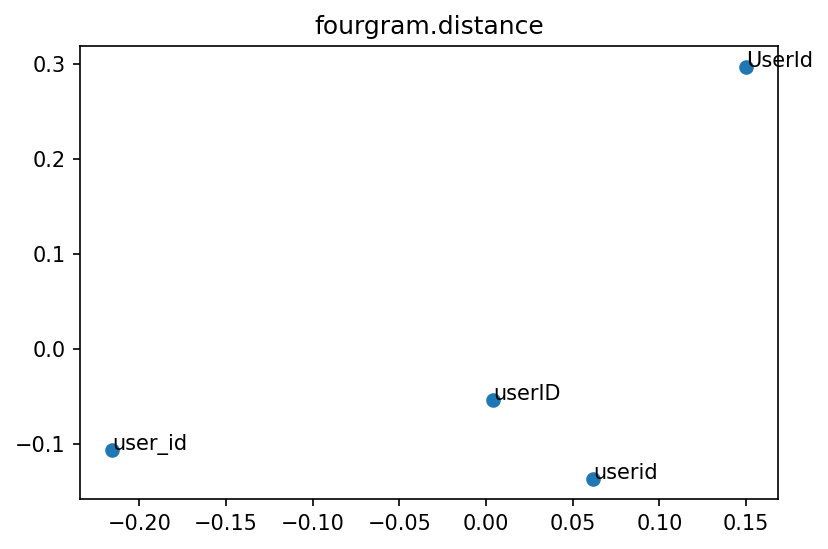

In [538]:
inconsistency_matrix = calculate_dissimilarity_matrix(similar_strings, fourgram.distance)
plot_words(inconsistency_matrix, title = "fourgram.distance", annotate=True)

#### Dice Coefficient and other Q-Gram based algorithms 

These algorithms use Q-grams, size $Q$ sets of characters from each string to compute distance. Q-gram distance is a lower bound on Levenshtein distance, but can be computed in $\mathcal{O}(M + N)$ , where as Levenshtein requires $\mathcal{O}(M \times N)$. There are numerous variations like Jaccard index, Cosine similarity, Szymkiewicz-Simpson, etc 




In [539]:
from strsimpy.sorensen_dice import SorensenDice
dice = SorensenDice(2)
print('The 2-dice.distance between {} and {} is {}'. \
    format(similar_strings[0], similar_strings[1], dice.distance(similar_strings[0], similar_strings[1])))

The 2-dice.distance between user_id and userid is 0.2727272727272727


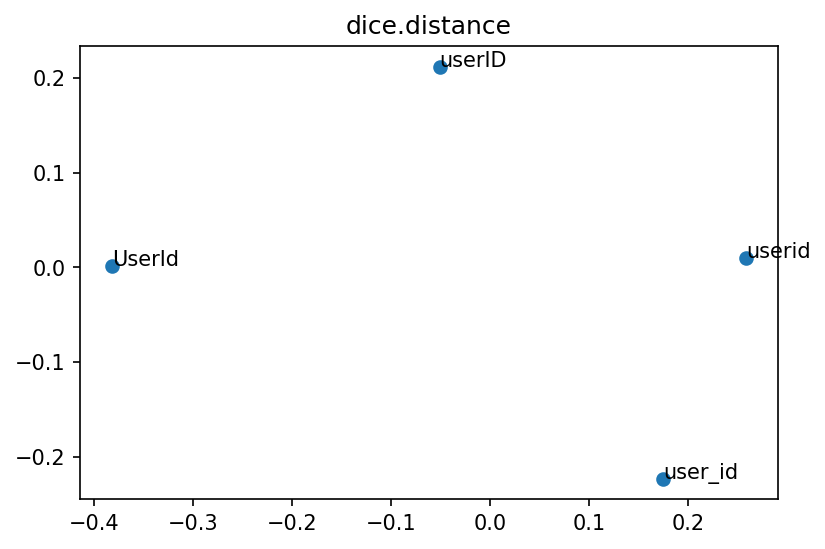

In [540]:
inconsistency_matrix = calculate_dissimilarity_matrix(similar_strings, dice.distance)
plot_words(inconsistency_matrix, title = "dice.distance", annotate=True)

#### Needleman-Wunsch Global Alignment
Global sequence alignment allows us to compare two strings and find the sequence of "mutations" that lead from one to the other. The goal of sequence alignment is to find homologous/similar sequences in the strings, and then base mutations off of the gaps that emerge between these sequences.


In [541]:

seq1 = Seq(similar_strings[0]) 
seq2 = Seq(similar_strings[1])
def global_alignment_score(string1, string2):
    alignments = pairwise2.align.globalms(seq1, seq2, 5, -4, -4, -4) # all alignment will have the same score, return any
    return alignments[0].score
# alignments = global_alignment_score(seq1, seq2)
# print(format_alignment(*alignments)) 
# print('The global_alignment_score distance between {} and {} is {}'. \
#     format(similar_strings[0], similar_strings[1], global_alignment_score(seq1, seq2)))

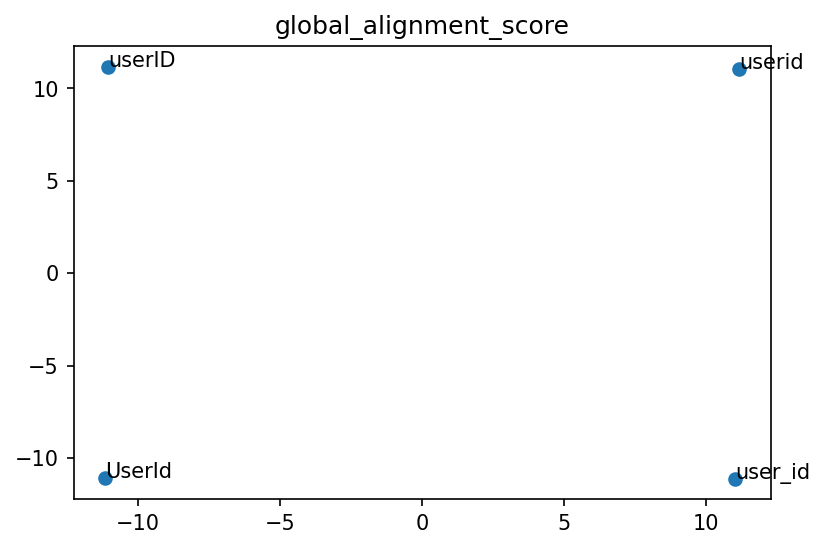

In [542]:
inconsistency_matrix = calculate_dissimilarity_matrix(similar_strings, global_alignment_score)
plot_words(inconsistency_matrix, title = "global_alignment_score", annotate=True)

#### SIFT 4 
This is an algorithm claimed to have been developed to produce a distance measure that matches as close as possible to the human perception of string distance. It takes into account elements like character substitution, character distance, longest common subsequence etc. However, It was developed using experimental testing, and without theoretical background.

In [543]:
from strsimpy import SIFT4

s = SIFT4()
print('The SIFT4 distance between {} and {} is {}'. \
    format(similar_strings[0], similar_strings[1], s.distance(similar_strings[0], similar_strings[1])))

The SIFT4 distance between user_id and userid is 1


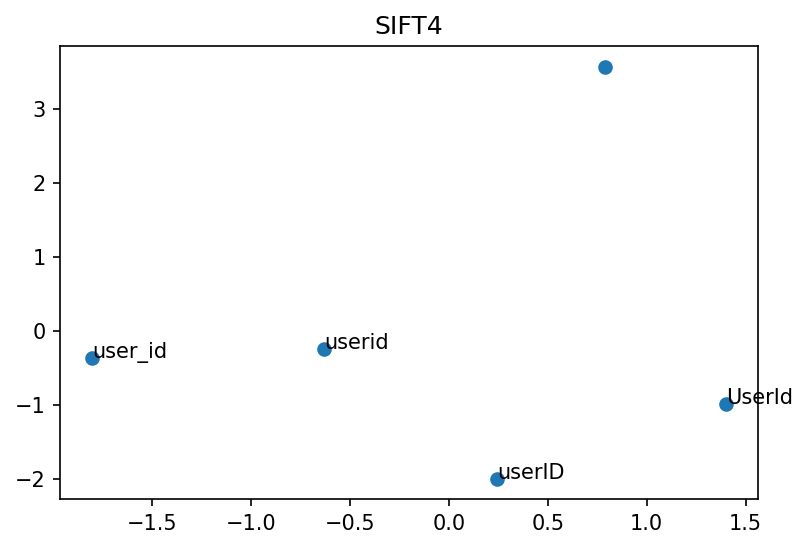

In [544]:
inconsistency_matrix = calculate_dissimilarity_matrix(similar_strings + ["Shruti"], s.distance)
plot_words(inconsistency_matrix, title = "SIFT4", annotate=True)

##### Using some of the algorithms to compute and plot the Google API vocabulary words

In [586]:
import pandas as pd

df = pd.read_csv (r'/home/gelaw/work-stuff/gocode/src/registry-experimental/consistency/rpc/google/cloud/apigeeregistry/v1/similarity/algorithms /vocab.csv')
words = []
for word in df.values:
    words.append(word[0]) 
print(words[0])
print(len(words))

Accelerator
5284


In [546]:
res = []
for word in words:
    if isinstance(word, float):
        print(word)
    else:
        res.append(word)
print(len(res))
        

nan
5283


In [547]:
inconsistency_matrix = calculate_dissimilarity_matrix(res[1:300], levenshtein.distance)


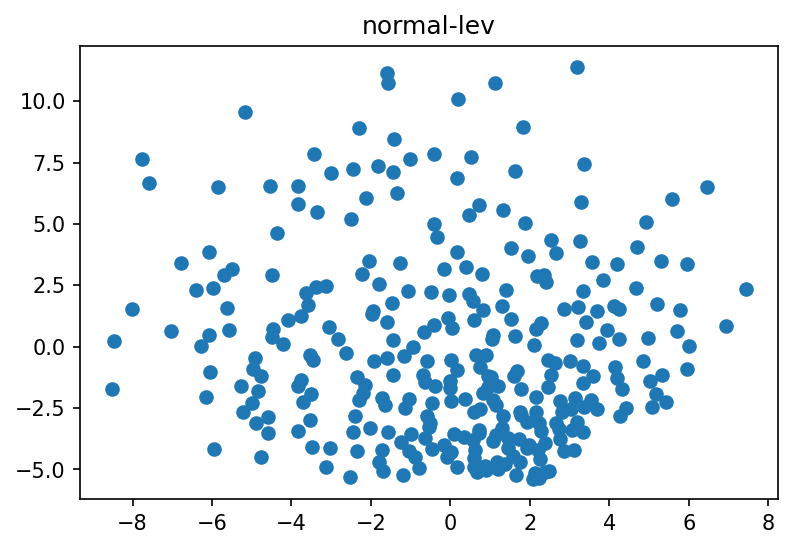

In [548]:
plot_words(inconsistency_matrix, title = "normal-lev", annotate=False)

In [549]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

def extract_lv (array_1, array_2):
    return levenshtein.distance(array_1[0], array_2[0])

def extract_nlv (array_1, array_2):
    return normalized_levenshtein.distance(array_1[0], array_2[0])

def extract_jarowinkler (array_1, array_2):
    return jarowinkler.distance(array_1[0], array_2[0])

def extract_lcs (array_1, array_2):
    return lcs.distance(array_1[0], array_2[0])

def extract_dice (array_1, array_2):
    return dice.distance(array_1[0], array_2[0])

def extract_global_alignment (array_1, array_2):
    return global_alignment_score(array_1[0], array_2[0])

def extract_sift4 (array_1, array_2):
    return s.distance(array_1[0], array_2[0])

algorithm_wrapper = {
  levenshtein: extract_lv,
  normalized_levenshtein: extract_nlv,
  jarowinkler: extract_jarowinkler,
  lcs: extract_lcs,
  dice: extract_dice,
  global_alignment_score: extract_global_alignment,
  s: extract_sift4
}


def efficient_dissimilarity_matrix(strings, dissimilarity_measuring_algorithm, return_square_matrix = True):
    condensed_matrix = pdist(strings, algorithm_wrapper[dissimilarity_measuring_algorithm])
    if return_square_matrix:
        return squareform(condensed_matrix)
    return condensed_matrix


In [550]:
reshaped_words = np.reshape(similar_strings, (len(similar_strings), 1))
print(reshaped_words)
print(reshaped_words.shape)


[['user_id']
 ['userid']
 ['UserId']
 ['userID']]
(4, 1)


In [551]:
matrixx = efficient_dissimilarity_matrix(reshaped_words, normalized_levenshtein)
print(matrixx)

[[0.         0.14285714 0.42857143 0.42857143]
 [0.14285714 0.         0.33333333 0.33333333]
 [0.42857143 0.33333333 0.         0.33333333]
 [0.42857143 0.33333333 0.33333333 0.        ]]


In [560]:

tagged_df = pd.read_csv (r'/home/gelaw/work-stuff/gocode/src/registry-experimental/consistency/rpc/google/cloud/apigeeregistry/v1/similarity/algorithms /vocab1000.csv')
tagged_df = tagged_df.drop(tagged_df.index[1000:])
word_labels = tagged_df.iloc[:, 0]
word_labels = word_labels.to_numpy()
tagged_words = tagged_df.iloc[:, 1]
tagged_words = tagged_words.to_numpy()

In [563]:
tagged_words_dissimilairty = efficient_dissimilarity_matrix(tagged_words.reshape(len(tagged_words), 1), normalized_levenshtein, return_square_matrix = True)

KeyError: <strsimpy.normalized_levenshtein.NormalizedLevenshtein object at 0x7d1fcf4604c0>

In [564]:
from strsimpy.normalized_levenshtein import NormalizedLevenshtein

normalized_levenshtein = NormalizedLevenshtein()
print(normalized_levenshtein.distance('My string', 'My string'))

0.0


In [582]:
from sklearn.cluster import dbscan
from leven import levenshtein    

In [608]:
     
data = tagged_words
print(data[0])

Abandon


In [621]:
levenshtein = Levenshtein()
def lev_metric(x, y):
    i, j = int(x[0]), int(y[0])     # extract indices
    return normalized_levenshtein.distance(data[i], data[j])
X = np.arange(len(data)).reshape(-1, 1)

db = dbscan(X, metric=lev_metric, eps=.2, min_samples=2, algorithm='brute')
#predicted = clustering.fit_predict(similar_strings)


In [624]:
# print(len(set(db[1])))
# print(db[1])




{0: 1.0}
[0.0, 0.0, 0.0, 0.0, 0.0]
{1: 0.5, 0: 0.5}
[0.0, 0.0, 0.0, 0.0, 0.0]
{3: 0.5, -1: 0.5}
[0.0, 0.0, 0.0, 0.0, 0.0]
{4: 0.5, 1: 0.5}
[0.0, 0.0, 0.0, 0.0, 0.0]
{6: 0.5, 1: 0.5}
[0.0, 0.0, 0.0, 0.0, 0.0]
{7: 0.5, -1: 0.5}
[0.0, 0.0, 0.0, 0.0, 0.0]
{17: 0.5, 1: 0.5}
[0.0, 0.0, 0.0, 0.0, 0.0]
{18: 0.5, 1: 0.5}
[0.0, 0.0, 0.0, 0.0, 0.0]
{19: 0.5, -1: 0.5}
[0.0, 0.0, 0.0, 0.0, 0.0]
{20: 0.5, -1: 0.5}
[0.0, 0.0, 0.0, 0.0, 0.0]
{21: 0.5, -1: 0.5}
[0.0, 0.0, 0.0, 0.0, 0.0]
{24: 0.5, -1: 0.5}
[0.0, 0.0, 0.0, 0.0, 0.0]
{25: 0.5, -1: 0.5}
[0.0, 0.0, 0.0, 0.0, 0.0]
{26: 0.5, -1: 0.5}
[0.0, 0.0, 0.0, 0.0, 0.0]
{27: 0.5, -1: 0.5}
[0.0, 0.0, 0.0, 0.0, 0.0]
{28: 0.5, -1: 0.5}
[0.0, 0.0, 0.0, 0.0, 0.0]
{29: 0.5, -1: 0.5}
[0.0, 0.0, 0.0, 0.0, 0.0]
{30: 0.5, 2: 0.5}
[0.0, 0.0, 0.0, 0.0, 0.0]
{31: 0.5, 2: 0.5}
[0.0, 0.0, 0.0, 0.0, 0.0]
{32: 0.5, 2: 0.5}
[0.0, 0.0, 0.0, 0.0, 0.0]
{33: 0.5, 2: 0.5}
[0.0, 0.0, 0.0, 0.0, 0.0]
{34: 0.5, 3: 0.5}
[0.0, 0.0, 0.0, 0.0, 0.0]
{35: 0.5, -1: 0.5}
[0.0, 0.0, 0.0, 

In [606]:
from leven import levenshtein       
import numpy as np
from sklearn.cluster import dbscan
data = ["ACCTCCTAGAAG", "ACCTACTAGAAGTT", "GAATATTA", "GAATATTAGGCCGAATCTTT", "GAATATTAGGCCGA", "GATAGGCCGA"]
def lev_metric(x, y):
    i, j = int(x[0]), int(y[0])     # extract indices
    return levenshtein(data[i], data[j])

X = np.arange(len(data)).reshape(-1, 1)
print(X)


[[0]
 [1]
 [2]
 [3]
 [4]
 [5]]


In [607]:



# We need to specify algoritum='brute' as the default assumes
# a continuous feature space.
db = dbscan(X, metric=lev_metric, eps=5, min_samples=2, algorithm='brute')
print(db)

(array([0, 1, 4, 5]), array([ 0,  0, -1, -1,  1,  1]))


In [595]:
from sklearn.cluster import DBSCAN
import numpy as np
X = np.array(["ACCTCCTAGAAG", "ACCTACTAGAAGTT", "GAATATTAGGCCGA"]).reshape(-1, 1)


In [597]:
clustering = DBSCAN(metric=lev_metric, eps=3, min_samples=2).fit(X)
clustering.labels_



ValueError: dtype='numeric' is not compatible with arrays of bytes/strings.Convert your data to numeric values explicitly instead.